In [1]:
# Import required libraries
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, accuracy_score

## 1. SETUP: Load Model and Define Data


In [2]:
# Load pre-trained BERT tokenizer and model
print("Loading BERT model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
print("Model loaded successfully.")


Loading BERT model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weig

Model loaded successfully.


In [3]:
# Define the 10 sentence pairs for comparison
sentence_pairs = [
    ("How do I learn Python?", "What is the best way to study Python?"),          # Similar
    ("What is AI?", "How to cook pasta?"),                                      # Not Similar
    ("How do I bake a chocolate cake?", "Give me a chocolate cake recipe."),      # Similar
    ("How can I improve my coding skills?", "Tips for becoming better at programming."), # Similar
    ("Where can I buy cheap laptops?", "Best sites to find affordable computers."), # Similar
    ("He went to the bank to deposit money.", "She visited the river bank to relax."), # Not Similar (Polysemy)
    ("I love playing football on weekends.", "Soccer is my favorite hobby."),      # Similar
    ("The weather is nice today.", "I am learning machine learning."),          # Not Similar
    ("She read a book about history.", "She is reading a novel on past events."), # Similar
    ("The car stopped abruptly.", "The vehicle came to a sudden halt.")          # Similar
]


In [4]:
# Define the ground truth labels (1 for similar, 0 for not similar)
labels = [1, 0, 1, 1, 1, 0, 1, 0, 1, 1]

## 2. EMBEDDING FUNCTION

In [5]:
def get_sentence_embedding(sentence):
    """
    Generates a sentence embedding using mean pooling.
    This provides a better semantic representation than using the [CLS] token alone.
    """
    # Tokenize the sentence and return TensorFlow tensors
    inputs = tokenizer(sentence, return_tensors='tf', truncation=True, padding=True)

    # Get the model's last hidden state
    outputs = bert_model(inputs)
    last_hidden_state = outputs.last_hidden_state

    # Perform mean pooling: average the embeddings of all tokens
    # We ignore the [CLS] and [SEP] tokens by slicing [:, 1:-1, :]
    sentence_embedding = tf.reduce_mean(last_hidden_state[:, 1:-1, :], axis=1)

    return sentence_embedding.numpy()

## 3. COMPUTE SIMILARITY AND PREDICTIONS

In [6]:
similarities = []
predictions = []
threshold = 0.7  # Define the similarity threshold

for i, (sent1, sent2) in enumerate(sentence_pairs):
    # Generate robust sentence embeddings using our corrected function
    emb1 = get_sentence_embedding(sent1)
    emb2 = get_sentence_embedding(sent2)

    # Compute cosine similarity
    sim_score = cosine_similarity(emb1, emb2)[0][0]
    similarities.append(sim_score)

    # Apply threshold to predict the label
    pred = 1 if sim_score > threshold else 0
    predictions.append(pred)

    # Display results for each pair
    print(f"\nPair {i+1}:")
    print(f"  Sentence 1: {sent1}")
    print(f"  Sentence 2: {sent2}")
    print(f"  Similarity Score: {sim_score:.4f} → Ground Truth: {labels[i]}, Predicted: {pred}")


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.



Pair 1:
  Sentence 1: How do I learn Python?
  Sentence 2: What is the best way to study Python?
  Similarity Score: 0.8159 → Ground Truth: 1, Predicted: 1

Pair 2:
  Sentence 1: What is AI?
  Sentence 2: How to cook pasta?
  Similarity Score: 0.5712 → Ground Truth: 0, Predicted: 0

Pair 3:
  Sentence 1: How do I bake a chocolate cake?
  Sentence 2: Give me a chocolate cake recipe.
  Similarity Score: 0.8207 → Ground Truth: 1, Predicted: 1

Pair 4:
  Sentence 1: How can I improve my coding skills?
  Sentence 2: Tips for becoming better at programming.
  Similarity Score: 0.6666 → Ground Truth: 1, Predicted: 0

Pair 5:
  Sentence 1: Where can I buy cheap laptops?
  Sentence 2: Best sites to find affordable computers.
  Similarity Score: 0.7322 → Ground Truth: 1, Predicted: 1

Pair 6:
  Sentence 1: He went to the bank to deposit money.
  Sentence 2: She visited the river bank to relax.
  Similarity Score: 0.6874 → Ground Truth: 0, Predicted: 0

Pair 7:
  Sentence 1: I love playing footb

In [9]:
# Calculate the accuracy score
accuracy = accuracy_score(labels, predictions)

# Print the result formatted as a percentage
print(f"Final Accuracy: {accuracy:.2%}")

Final Accuracy: 90.00%


## 4. EVALUATION AND VISUALIZATION

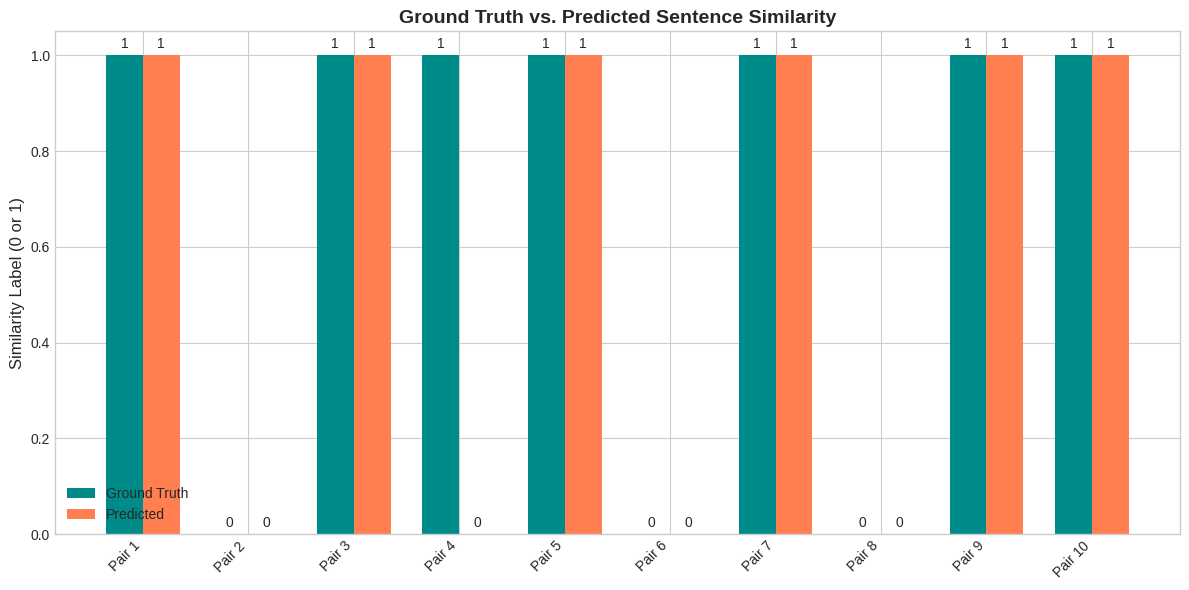

In [7]:
# --- Plot 1: Bar Chart of Ground Truth vs. Predicted Labels ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(sentence_pairs))
width = 0.35

rects1 = ax.bar(x - width/2, labels, width, label='Ground Truth', color='darkcyan')
rects2 = ax.bar(x + width/2, predictions, width, label='Predicted', color='coral')

ax.set_ylabel('Similarity Label (0 or 1)', fontsize=12)
ax.set_title('Ground Truth vs. Predicted Sentence Similarity', fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"Pair {i+1}" for i in range(len(labels))], rotation=45, ha="right")
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

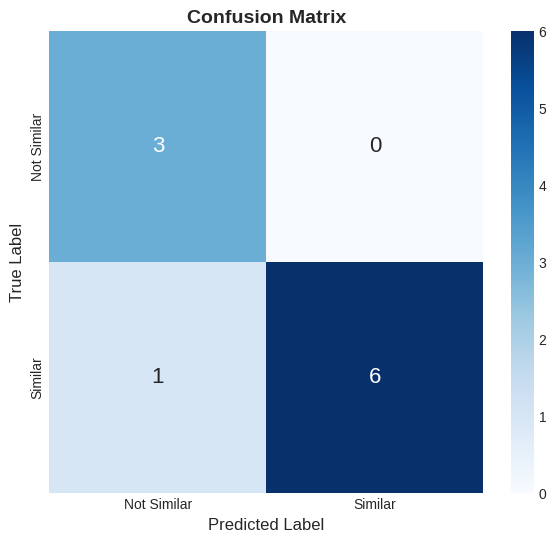

In [8]:
# --- Plot 2: Confusion Matrix ---
cm = confusion_matrix(labels, predictions)
cm_labels = ['Not Similar', 'Similar']

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cm_labels, yticklabels=cm_labels, annot_kws={"size": 16})

plt.title("Confusion Matrix", fontsize=14, weight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()